## Environment set up and import Libraries

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')
import os
# os.getcwd()
# os.listdir()

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

In [3]:
import tensorflow as tf
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

C:\Users\Dipankar Porey\anaconda3\envs\tensorflow_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [71]:
import os, keras, numpy,tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *
from tensorflow.keras import initializers

## **Discriminator** Model

In [72]:
def define_discriminator(in_shape=(64,64,3),n_classes=5):

    # input level
    label_layer_1 = Input(shape=(1,), name = "input_label")
    label_layer_2 = Embedding(n_classes, 100)(label_layer_1)
    label_layer_3 = Dense(in_shape[0] * in_shape[1])(label_layer_2)
    label_layer_4 = Reshape((in_shape[0], in_shape[1], 1))(label_layer_3)
    # (64, 64, 1)

    # input image
    input_image = Input(shape=in_shape, name = "input_image")
    # (64, 64, 3)

    concat_layer = Concatenate()([input_image, label_layer_4])
    # (64, 64, 4)

    conv2d_layer_1 = Conv2D(filters = 16, kernel_size = (3,3), strides = (2,2), padding='same')(concat_layer)
    conv2d_layer_1 = LeakyReLU(alpha=0.3)(conv2d_layer_1)
    # (32, 32, 16)

    conv2d_layer_2 = Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_1)
    conv2d_layer_2 = LeakyReLU(alpha=0.3)(conv2d_layer_2)
    # (16, 16, 32)

    conv2d_layer_3 = Conv2D(filters = 64, kernel_size = (3,3),  strides = (2,2), padding = 'same')(conv2d_layer_2)
    conv2d_layer_3 = LeakyReLU(alpha=0.3)(conv2d_layer_3)
    # (8, 8, 64)

    conv2d_layer_4 = Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_3)
    conv2d_layer_4 = LeakyReLU(alpha=0.3)(conv2d_layer_4)
    # (4, 4, 128)

    flatten_layer = Flatten()(conv2d_layer_4)
    # (4 * 4 * 128)

    dropout_layer = Dropout(rate=0.4)(flatten_layer)
    # (4 * 4 * 128)

    dense_layer = Dense(128*8, activation='relu')(dropout_layer)
    # (8 * 128)

    # final layer
    output_layer = Dense(1, activation='sigmoid')(dense_layer)
    # (1,)

    model = Model([input_image,label_layer_1], output_layer)

    opt = Adam(learning_rate= 3e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

a = define_discriminator()
a.summary()

In [73]:
# plot the discriminator model
tf.keras.utils.plot_model(a,to_file='discriminator.png',show_shapes=True,show_layer_names=True)

## **Generator** Model

In [74]:
def define_generator(latent_dim = 100, n_classes = 5):

    # input level
    label_layer_1 = Input(shape=(1,), name = "input_label")
    label_layer_2 = Embedding(n_classes, 100)(label_layer_1)
    label_layer_3 = Dense(8 * 8)(label_layer_2)
    label_layer_4 = Reshape((8, 8, 1))(label_layer_3)
    # (8, 8, 1)

    # latent input
    latent_layer = Input(shape=(latent_dim,), name = "input_latent")

    layer_2 = Dense(128 * 8 * 8)(latent_layer)
    layer_2 = Activation("relu")(layer_2)
    layer_2 = Reshape((8, 8, 128))(layer_2)
    layer_2_1 = BatchNormalization(momentum = 0.8)(layer_2)
    # (8, 8, 128)


    concat_layer_1 = Concatenate()([layer_2_1, label_layer_4])
    # (8, 8, 129)

    layer_3 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(concat_layer_1)
    layer_3 = Conv2D(filters = 128, kernel_size = (3,3), padding='same', kernel_initializer = initializers.RandomNormal(0,0.8))(layer_3)
    layer_3 = BatchNormalization(momentum = 0.8)(layer_3)
    layer_3 = LeakyReLU(alpha=0.4)(layer_3)
    # (16, 16, 128)

    layer_4 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(layer_3)
    layer_4 = Conv2D(filters = 128, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_4)
    layer_4 = BatchNormalization(momentum = 0.8)(layer_4)
    layer_4 = LeakyReLU(alpha=0.4)(layer_4)
    # (32, 32, 128)

    layer_5 = Conv2DTranspose(filters = 256, kernel_size = (3,3), strides=(2,2), padding='same')(layer_4)
    layer_5 = Conv2D(filters = 256, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_5)
    layer_5 = BatchNormalization(momentum = 0.8)(layer_5)
    layer_5 = LeakyReLU(alpha=0.4)(layer_5)
    # (64, 64, 128)

    # final layer
    output_layer = Conv2D(filters = 3, kernel_size = (3,3), strides=(1,1), activation='tanh', padding='same')(layer_5)

    model = Model([latent_layer,label_layer_1], output_layer)
    return model

b = define_generator(512)
b.summary()

In [75]:
# plot the generator model
tf.keras.utils.plot_model(b,to_file='generator.png',show_shapes=True,show_layer_names=True)

## **Combine** or **GAN** Model

In [76]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  g_latent, g_label = g_model.input
  g_output = g_model.output

  d_output = d_model([g_output,g_label])

  model = Model([g_latent, g_label], d_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

In [77]:
# plot GAN model
tf.keras.utils.plot_model(c,to_file='combined_gan.png',show_shapes=True,show_layer_names=True)

## Load Dataset

In [78]:
def load_real_samples():
  # load dataset
  data = np.load("../input/animo30k/Animo30k.npz")
  data = data['a']
  data = np.array(data)
  X = data.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X
# k = load_real_samples()
# print("image: ",k.shape)
# print("\nshape/size of the first 16 data: ",k[:16].shape)

## Plot data with label

In [79]:
def save_plot(x_input,n=4):
    plt.figure(figsize=(10,7))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
    plt.show()
# plot data
# save_plot(k[:16])

## Generate real sample function

In [80]:
def generate_real_samples(dataset, n_samples):
	images = dataset
	ix = randint(0, images.shape[0], n_samples)
	X = images[ix]
	z = np.random.randint(0,5,size=(n_samples))
	y = ones((n_samples, 1))
	return [X,z], y
# d = generate_real_samples(k, 32)
# print("Generate real data as a batch randomly: ",d[0][0].shape)

## Generate latent point function

In [81]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  z = np.random.randint(0,5,size=(n_samples))
  return [z_input,z]
# p = generate_latent_points(512, 32)
# print("Generate latent point(with label) as a batch: ",p[0].shape)

## Generate Fake samples of image with label

In [82]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input,z = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input,z])
	y = zeros((n_samples, 1))
	return [images, z], y
# with tf.device(device_name):
# 	kh = generate_fake_samples(b, 512, 32)
# 	print("shape of the generated images: ",kh[0][0].shape)

## Summarize the generator model

In [83]:
def summarize_the_model(generator,latent_dim = 100):
    latent_points = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, n=4)

In [84]:
def save_figure(generator,a,latent_dim = 512,n=4):
    latent_points, labels = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict([latent_points, labels])
    # plt.title("Epoch_"+str(a+1),loc = "center")
    for j in range(n*n):
        plt.subplot(n, n, j+1)
        plt.imshow(X[j,:,:,:])
        plt.axis('off')
    plt.suptitle("Epoch_"+str(a+1))
    plt.savefig("/content/drive/MyDrive/Animo/GAN_new_approch/1/epoch_"+str(a+1))

## Train function

In [85]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=128):

  print("No. of epoch: ",n_epochs)
  bat_per_epo = int(dataset.shape[0] / n_batch)
  print("Data size: ",dataset.shape[0])
  print("batch per epoch: ", bat_per_epo)
  print("full batch: ",n_batch)
  half_batch = int(n_batch / 2)
  print("half batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  d_loss_real_array,d_loss_fake_array =[],[]
  g_loss_array = []
  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      d_loss_r += (d_loss1 / half_batch)
      # print("real_loss")

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      d_loss_f += (d_loss2 / half_batch)
      # print("fake_loss")

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch([z_input, labels_input], y_gan)
      g_loss += (g_loss1 / n_batch)

    d_loss_real_array.append(d_loss_r/bat_per_epo)
    d_loss_fake_array.append(d_loss_f/bat_per_epo)
    g_loss_array.append(g_loss/bat_per_epo)

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %f, discriminator_loss_for_fake_data = %f, generator_loss = %f\n' %(i+1, n_epochs, d_loss_r/bat_per_epo, d_loss_f/bat_per_epo, g_loss/bat_per_epo))
    if((i+1)%5==0):
        summarize_the_model(g_model,latent_dim)
    g_model.save("generator_model_2.h5")
    np.savez_compressed('loss_record_2.npz', a=d_loss_real_array, b=d_loss_fake_array, c=g_loss_array)
    # save_figure(g_model,i,latent_dim = 512,n=4)

    print("\n")

  return d_loss_real_array, d_loss_fake_array, g_loss_array

## Main function

In [ ]:
with tf.device(device_name):

  latent_dim = 512
  n_epochs = 80
  n_batch = 32
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss_real_array, d_loss_fake_array, g_loss_array = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

## Plot Loss Values

In [ ]:
# g_model.save("/content/sample_data/generator_model_c_dcgan.h5")

In [8]:
loaded = np.load('loss_record_2.npz')
print(loaded['a'].shape)
print(loaded['b'].shape)

(80,)
(80,)


In [13]:
import matplotlib.pyplot as plt

d_loss_real_array = loaded['a']
d_loss_fake_array = loaded['b']

In [14]:
d_loss = np.array([(i+j) for i,j in zip(d_loss, d_loss_fake_array)])

In [15]:
g_loss = loaded['c']

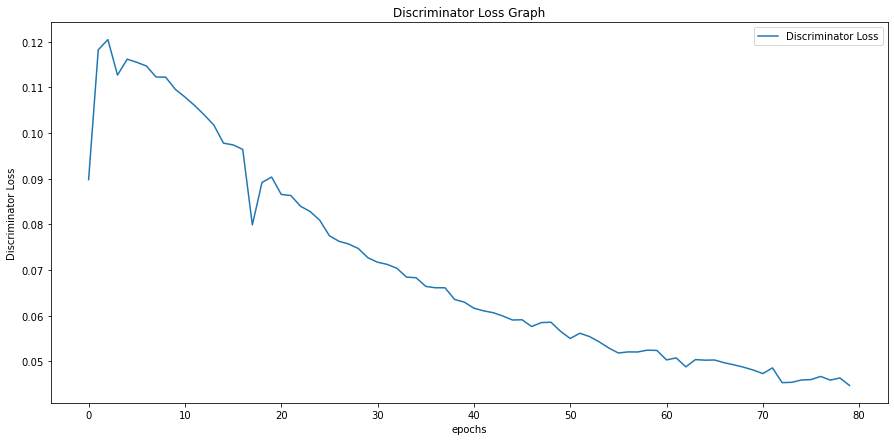

In [16]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.savefig("Discriminator_Loss_Graph")
plt.show()

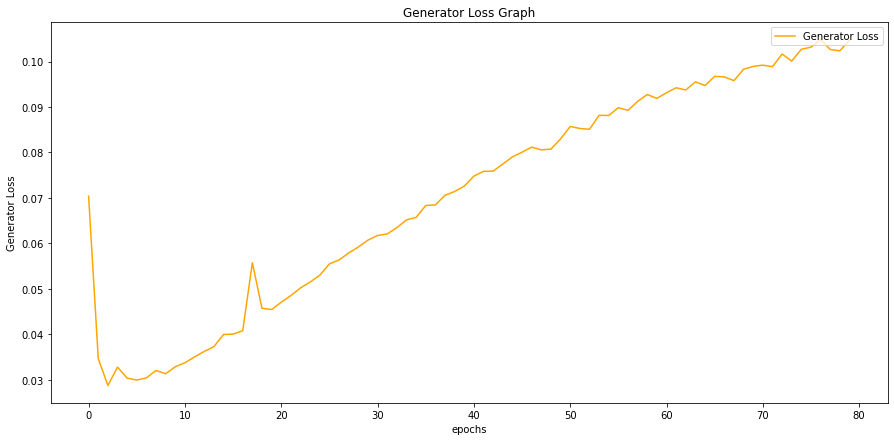

In [17]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.savefig("Generator_Loss_Graph")
plt.show()

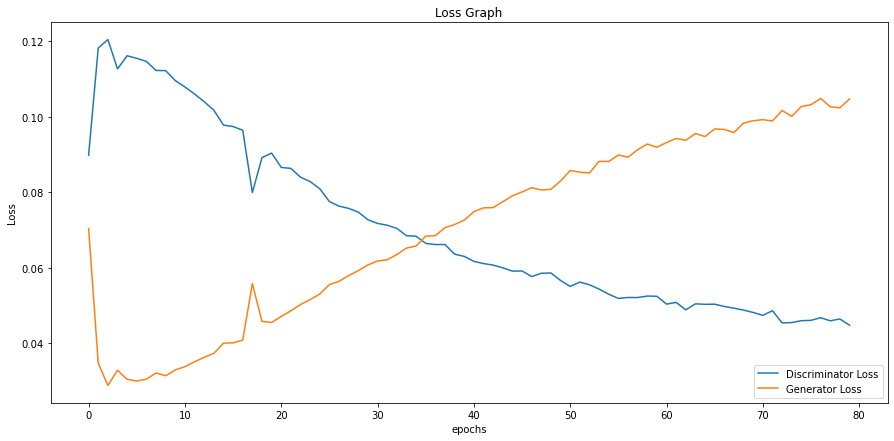

In [18]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.savefig("Loss_Graph")
plt.show()

# Prediction

In [ ]:
# generator = tensorflow.keras.models.load_model("/content/drive/MyDrive/Animo/GAN_new_approch/1/generator_model_2_1.h5")

In [ ]:
# latent_dim = 512
# n_samples = 16
# z_input, labels = generate_latent_points(latent_dim, n_samples)
# print("latent points(latent points and labels): ",z_input.shape, labels.shape)
# data = [z_input,labels]
# pred = generator.predict(data)
# pred = (pred +1 ) / 2.0
# print("\nGenerated images with labels: ",pred.shape,'\n')
# save_plot(pred,n=4)

                                              -:END:-